# Generate Simulation data from NASA planet database

This is an optional notebook that generates simulated orbits for planets from the NASA database (and a few extra ones "by hand" too!).

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# extra
from glob import glob

A few extra things we'll need in external libraries:

In [73]:
from convert_kepler_data import convert_kepler_data
from hermite_library import do_hermite, save_hermite_solution_to_file, read_hermite_solution_from_file

Read in database file:

In [41]:
#planets = pd.read_csv('https://jnaiman.github.io/csci-p-14110_su2020/lesson08/planets_2020.06.17_14.04.11.csv', 
#                     sep=",", comment="#")

planets = pd.read_csv('planets_2020.06.22_10.10.17.csv',sep=",", comment="#")

In [42]:
planets.head()

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
0,1,11 Com,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1,2,11 UMi,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,3,14 And,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
3,4,14 Her,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,...,0.537,0.001,0.0,0.366,0.002,0.0,0.438,0.006,0.0,9.0
4,5,16 Cyg B,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,...,0.418,0.003,0.0,0.222,0.003,0.0,0.351,0.003,0.0,17.0


In [43]:
len(planets)

4164

Now we choose systems to simulate.  I'm gonna pick all systems with > a number planets:

In [156]:
mask = planets['pl_pnum'] > 3

Subset dataframe:

In [157]:
multi_planets = planets[mask]

In [158]:
multi_planets

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
25,26,55 Cnc,b,55 Cnc b,Radial Velocity,0,5,14.651520,0.000150,-0.000150,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
26,27,55 Cnc,c,55 Cnc c,Radial Velocity,0,5,44.417500,0.007300,-0.007300,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
27,28,55 Cnc,d,55 Cnc d,Radial Velocity,0,5,4825.000000,39.000000,-39.000000,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
28,29,55 Cnc,e,55 Cnc e,Radial Velocity,0,5,0.736539,0.000007,-0.000007,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
29,30,55 Cnc,f,55 Cnc f,Radial Velocity,0,5,262.000000,0.510000,-0.510000,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,4050,WASP-47,e,WASP-47 e,Transit,0,4,0.789592,0.000012,-0.000012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4155,4156,tau Cet,e,tau Cet e,Radial Velocity,0,4,162.870000,1.080000,-0.460000,...,0.438,0.002,0.0,0.263,0.003,0.0,0.240,0.004,0.0,21.0
4156,4157,tau Cet,f,tau Cet f,Radial Velocity,0,4,636.130000,11.700000,-47.690000,...,0.438,0.002,0.0,0.263,0.003,0.0,0.240,0.004,0.0,21.0
4157,4158,tau Cet,g,tau Cet g,Radial Velocity,0,4,20.000000,0.020000,-0.010000,...,0.438,0.002,0.0,0.263,0.003,0.0,0.240,0.004,0.0,21.0


Make new dataframe that only includes dynamical elements of interest *for each system*:

In [159]:
names = np.unique(multi_planets['pl_hostname'].values)
names

array(['55 Cnc', 'DMPP-1', 'GJ 3293', 'GJ 667 C', 'GJ 676 A', 'GJ 876',
       'HD 10180', 'HD 141399', 'HD 158259', 'HD 160691', 'HD 20781',
       'HD 20794', 'HD 215152', 'HD 219134', 'HD 34445', 'HD 40307',
       'HIP 41378', 'HR 8799', 'K2-133', 'K2-138', 'K2-187', 'K2-266',
       'K2-285', 'K2-32', 'K2-72', 'KOI-351', 'KOI-94', 'Kepler-102',
       'Kepler-106', 'Kepler-107', 'Kepler-11', 'Kepler-122',
       'Kepler-132', 'Kepler-1388', 'Kepler-150', 'Kepler-154',
       'Kepler-1542', 'Kepler-167', 'Kepler-169', 'Kepler-172',
       'Kepler-176', 'Kepler-186', 'Kepler-197', 'Kepler-20',
       'Kepler-208', 'Kepler-215', 'Kepler-220', 'Kepler-221',
       'Kepler-223', 'Kepler-224', 'Kepler-235', 'Kepler-238',
       'Kepler-24', 'Kepler-245', 'Kepler-251', 'Kepler-256', 'Kepler-26',
       'Kepler-265', 'Kepler-282', 'Kepler-286', 'Kepler-292',
       'Kepler-296', 'Kepler-299', 'Kepler-304', 'Kepler-306',
       'Kepler-32', 'Kepler-33', 'Kepler-338', 'Kepler-341', 'Kepler-

In [169]:
savedNames = []
savedSims = []

for iname,name in enumerate(names): # for each planetary system
    print('On ' + name + ' - ' + str(iname+1) + ' of ' + str(len(names)) + ' systems')
    # only select entries with this name
    mask = multi_planets['pl_hostname'] == name
    ecc = multi_planets['pl_orbeccen'][mask]
    a = multi_planets['pl_orbsmax'][mask]
    Porb = multi_planets['pl_orbper'][mask]
    Incl = multi_planets['pl_orbincl'][mask]
    sMass = multi_planets['st_mass'][mask]
    pMass = multi_planets['pl_bmassj'][mask]
    tTime = multi_planets['pl_orbtper'][mask]

    # if no incl, set to zero
    Incl[np.isnan(Incl)] = 0.0
    
    # if no tTime set to zero
    tTime[np.isnan(tTime)] = 0.0

    ecc[np.isnan(ecc)] = 0.0

    # now convert to kepler data dictionary
    # only entries we really need to use in the convert_kepler_data function
    kepler_data = {}

    mask2 = ~np.isnan(pMass) & ~np.isnan(a.values) & ~np.isnan(sMass)# check for actual storage
    kepler_data['SysName'] = name
    kepler_data['NumberOfPlanets'] = len(a[mask2]) 
    kepler_data['Porb'] = Porb.values[mask2]
    kepler_data['a']=a.values[mask2]
    kepler_data['ecc']=ecc.values[mask2]
    kepler_data['Incl']=Incl.values[mask2]
    kepler_data['pMass']=pMass.values[mask2]
    kepler_data['sMass']=sMass.values[mask2]
    kepler_data['tTime']=tTime.values[mask2]
    
    
    
    #print(len(kepler_data['pMass']))

    # calculate inputs for sims
    #if len(kepler_data['pMass']) > 0 and len(kepler_data['a'][~np.isnan(kepler_data['a'])]) > 0:
    if len(kepler_data['pMass']) > 0:
        star_mass, \
        planet_masses, \
        planet_initial_position, \
        planet_initial_velocity, ecc = convert_kepler_data(kepler_data)
        
        # do the sim!
        # uses a hermite solution
        r_h, v_h, t_h, e_h = do_hermite(star_mass, 
                                planet_masses, 
                                planet_initial_position, 
                                planet_initial_velocity, 
                               tfinal=1e7, Nsteps=8800, 
                                        threeDee=True)
        
        # if all nan's stop a moment
        if len(r_h[~np.isnan(r_h)]) == 0:
            import sys
            sys.exit()
        
        # save
        #savedNames.append(name)
        #savedSims.append( (r_h, v_h, t_h, e_h) )
        saveName = "_".join(name.split()) + '-savedSim.txt'
        
        # you can save it to your local directory, or another place
        save_hermite_solution_to_file('data/' + saveName, 
                                  t_h, e_h, r_h, v_h)
        print('   saved: data/' + saveName)
    else:
        print('   NO masses or as -- nothing saved for ' + name)

On 55 Cnc - 1 of 89 systems
   saved: data/55_Cnc-savedSim.txt
On DMPP-1 - 2 of 89 systems
   saved: data/DMPP-1-savedSim.txt
On GJ 3293 - 3 of 89 systems
   saved: data/GJ_3293-savedSim.txt
On GJ 667 C - 4 of 89 systems
   saved: data/GJ_667_C-savedSim.txt
On GJ 676 A - 5 of 89 systems
   saved: data/GJ_676_A-savedSim.txt
On GJ 876 - 6 of 89 systems
   saved: data/GJ_876-savedSim.txt
On HD 10180 - 7 of 89 systems
   saved: data/HD_10180-savedSim.txt
On HD 141399 - 8 of 89 systems
   saved: data/HD_141399-savedSim.txt
On HD 158259 - 9 of 89 systems
   NO masses or as -- nothing saved for HD 158259
On HD 160691 - 10 of 89 systems
   saved: data/HD_160691-savedSim.txt
On HD 20781 - 11 of 89 systems
   saved: data/HD_20781-savedSim.txt
On HD 20794 - 12 of 89 systems
   saved: data/HD_20794-savedSim.txt
On HD 215152 - 13 of 89 systems
   saved: data/HD_215152-savedSim.txt
On HD 219134 - 14 of 89 systems
   saved: data/HD_219134-savedSim.txt
On HD 34445 - 15 of 89 systems
   saved: data/HD_

In [170]:
#~np.isnan(a.values) & ~np.isnan(pMass)

In [171]:
#print(star_mass)
#print(planet_masses)
#print(planet_initial_position)
#print(planet_initial_velocity)
#print(ecc)
#print(' ')
for item in kepler_data:
    print(item, kepler_data[item])
    
print(' ')
print(len(a.values[~np.isnan(a.values)]))
print(a.values)
print(pMass)

SysName tau Cet
NumberOfPlanets 4
Porb [162.87 636.13  20.    49.41]
a [0.538 1.334 0.133 0.243]
ecc [0.18 0.16 0.06 0.23]
Incl [0. 0. 0. 0.]
pMass [0.01237 0.01237 0.00551 0.00576]
sMass [0.78 0.78 0.78 0.78]
tTime [0. 0. 0. 0.]
 
4
[0.538 1.334 0.133 0.243]
4155    0.01237
4156    0.01237
4157    0.00551
4158    0.00576
Name: pl_bmassj, dtype: float64


Groovy.  Now we can read in some of this data and plot it if we wanna:

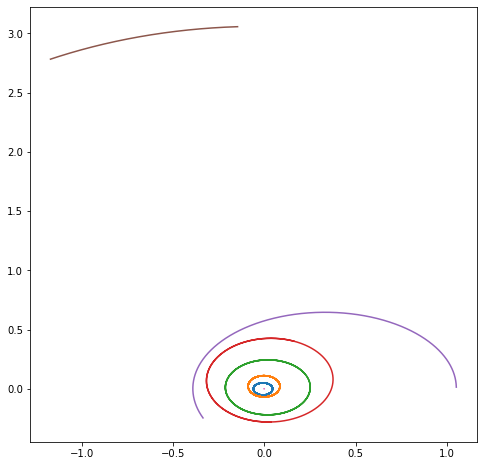

In [172]:
read_in_name = 'HD 10180'
#read_in_name = 'Kepler-238'

fname = saveName = "_".join(read_in_name.split()) + '-savedSim.txt'
t_h, E_h, r_h, v_h = read_hermite_solution_from_file('data/' + fname)

# plot the sim
fig, ax = plt.subplots(1,1, figsize=(8,8))

# loop over the number of particles in our system (star + planets)
for i in range(r_h.shape[0]):
    # on the 0th i.e. first set of axis plot
    # the ith planet
    # the 0th (x) axis vs the 1st (y) axis
    # and plot all the time steps (:)
    ax.plot(r_h[i,0,:], r_h[i, 1, :])
    

plt.show()

In [173]:
#r_h[~np.isnan(r_h)]

Or, do all the orbits:

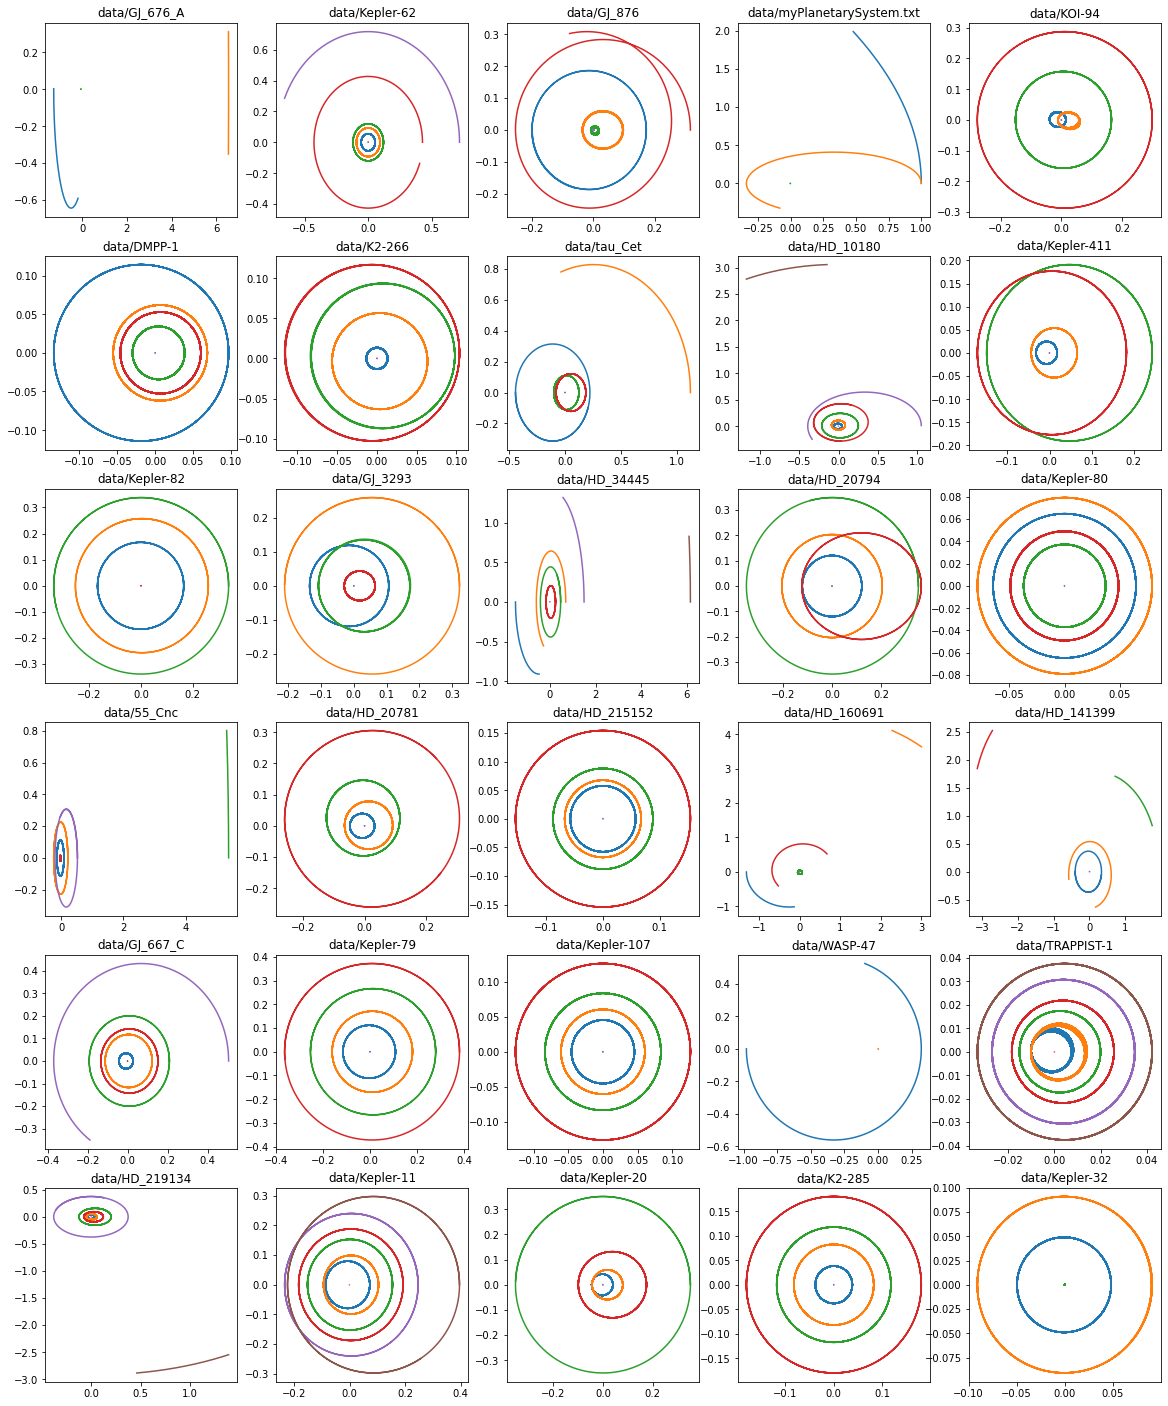

In [174]:
nx = 5
ny = 6

# for 1x1
baseWidth = 5/(nx/4)
baseHeight = 5/(ny/5)

fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize = (baseWidth*nx, baseHeight*ny))
# flatten for easier manipulation
ax = ax.flatten()

ffiles = glob('data/*txt')

for j in range(len(ax)):
    if j < len(ffiles):
        t_h, E_h, r_h, v_h = read_hermite_solution_from_file(ffiles[j])

        # loop over the number of particles in our system (star + planets)
        for i in range(r_h.shape[0]):
            ax[j].plot(r_h[i,0,:], r_h[i, 1, :])
            
        # title
        title = ffiles[j].split('-savedSim')[0]
        ax[j].set_title(title)
    else: # else, turn off all axis
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        # for minor ticks
        ax[j].set_xticks([], minor=True)
        ax[j].set_yticks([], minor=True)
        # axlis lines
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].spines['bottom'].set_visible(False)
        
plt.show()

One can also make their own systems "by hand" if one chooses:

In [175]:
star_mass = 1.0 # stellar mass in Msun
planet_masses = np.array( [1.0, 0.5] ) # planet masses in Mjupiter

# [x,y,z] coords for each planet in AU
planet_initial_position = np.array([ [1.0, 0.0, 1.0], 
                                     [1.0, 0.0, 0.0]])

# planet's velocity at each position in km/s
planet_initial_velocity = np.array([ [0.0, 35,   0.0],
                                     [0.0, 15.0, 15.0]])

# note: this assumes that the star is at (0, 0, 0) and has zero 
#  initial velocity

In [176]:
r_h, v_h, t_h, E_h = do_hermite(star_mass, 
                                planet_masses, 
                                planet_initial_position, 
                                planet_initial_velocity, 
                               tfinal=1e7, Nsteps=8800,
                               threeDee=True) 

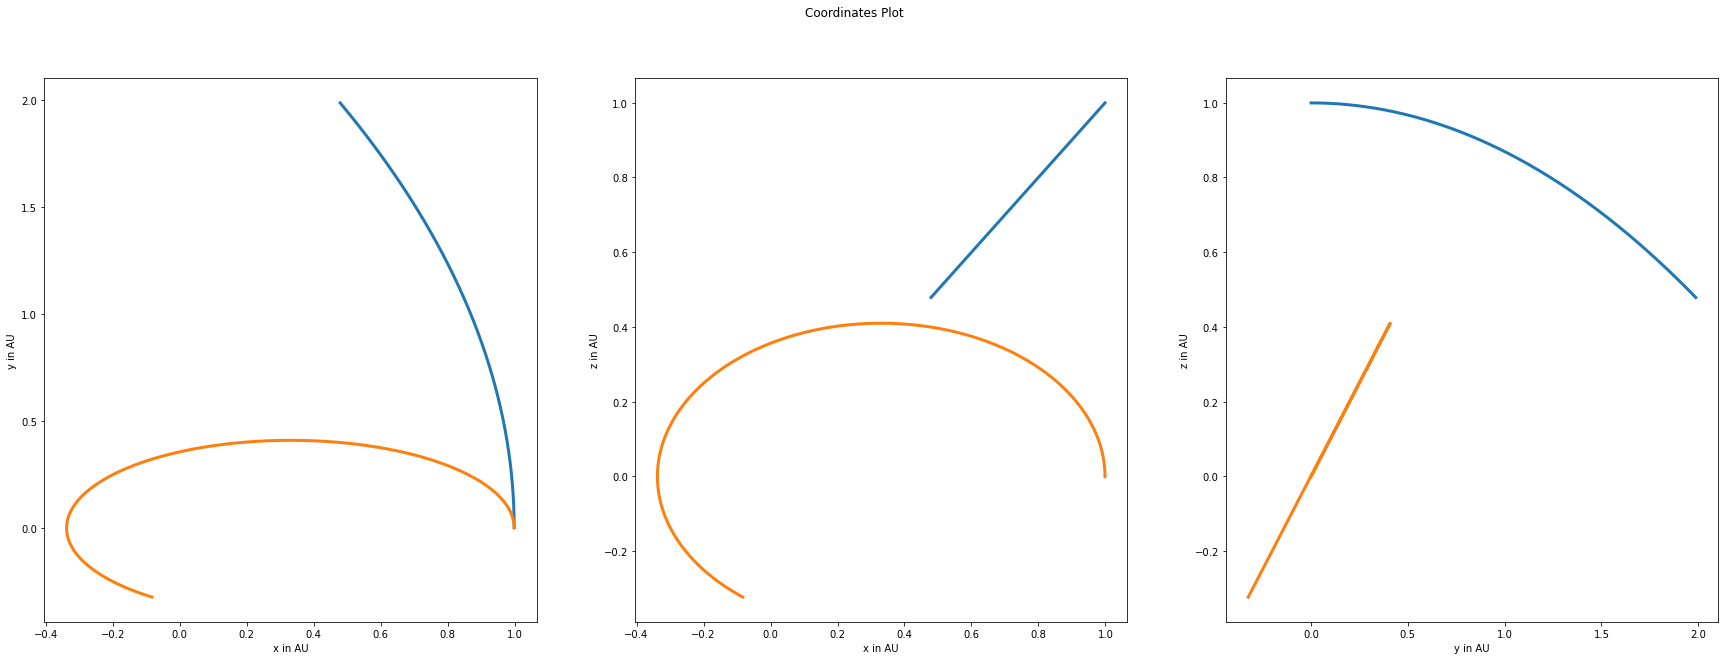

In [177]:
# now make 3 plots instead of 1
fig, ax = plt.subplots(1, 3, figsize = (10*3, 10))
fig.suptitle('Coordinates Plot')

# X vs Y means 0th vs 1st coordinate axes
# ax[0] means first plot
# recall:
# r_h[NUMBER OF PARTICLES, NUMBER COORDINATES (X,Y,Z), NUMBER OF TIMESTEPS]
ax[0].set_xlabel('x in AU')
ax[0].set_ylabel('y in AU')
for i in range(len(planet_masses)):
    ax[0].plot(r_h[i,0,:], r_h[i,1,:], lw=3)

# X vs Z means 0th vs 2nd coordinate axes
# ax[1] means 2nd plot
ax[1].set_xlabel('x in AU')
ax[1].set_ylabel('z in AU')
for i in range(len(planet_masses)):
    ax[1].plot(r_h[i,0,:], r_h[i,2,:], lw=3)

# Y vs Z means 1th vs 2nd coordinate axes
# ax[2] means 3rd plot
ax[2].set_xlabel('y in AU')
ax[2].set_ylabel('z in AU')
for i in range(len(planet_masses)):
    ax[2].plot(r_h[i,1,:], r_h[i,2,:], lw=3)

plt.show()

In [178]:
save_hermite_solution_to_file('data/' + 'myPlanetarySystem.txt', t_h, e_h, r_h, v_h)